In [4]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
plt.style.use('../peptidome.mplstyle')

from lib import *

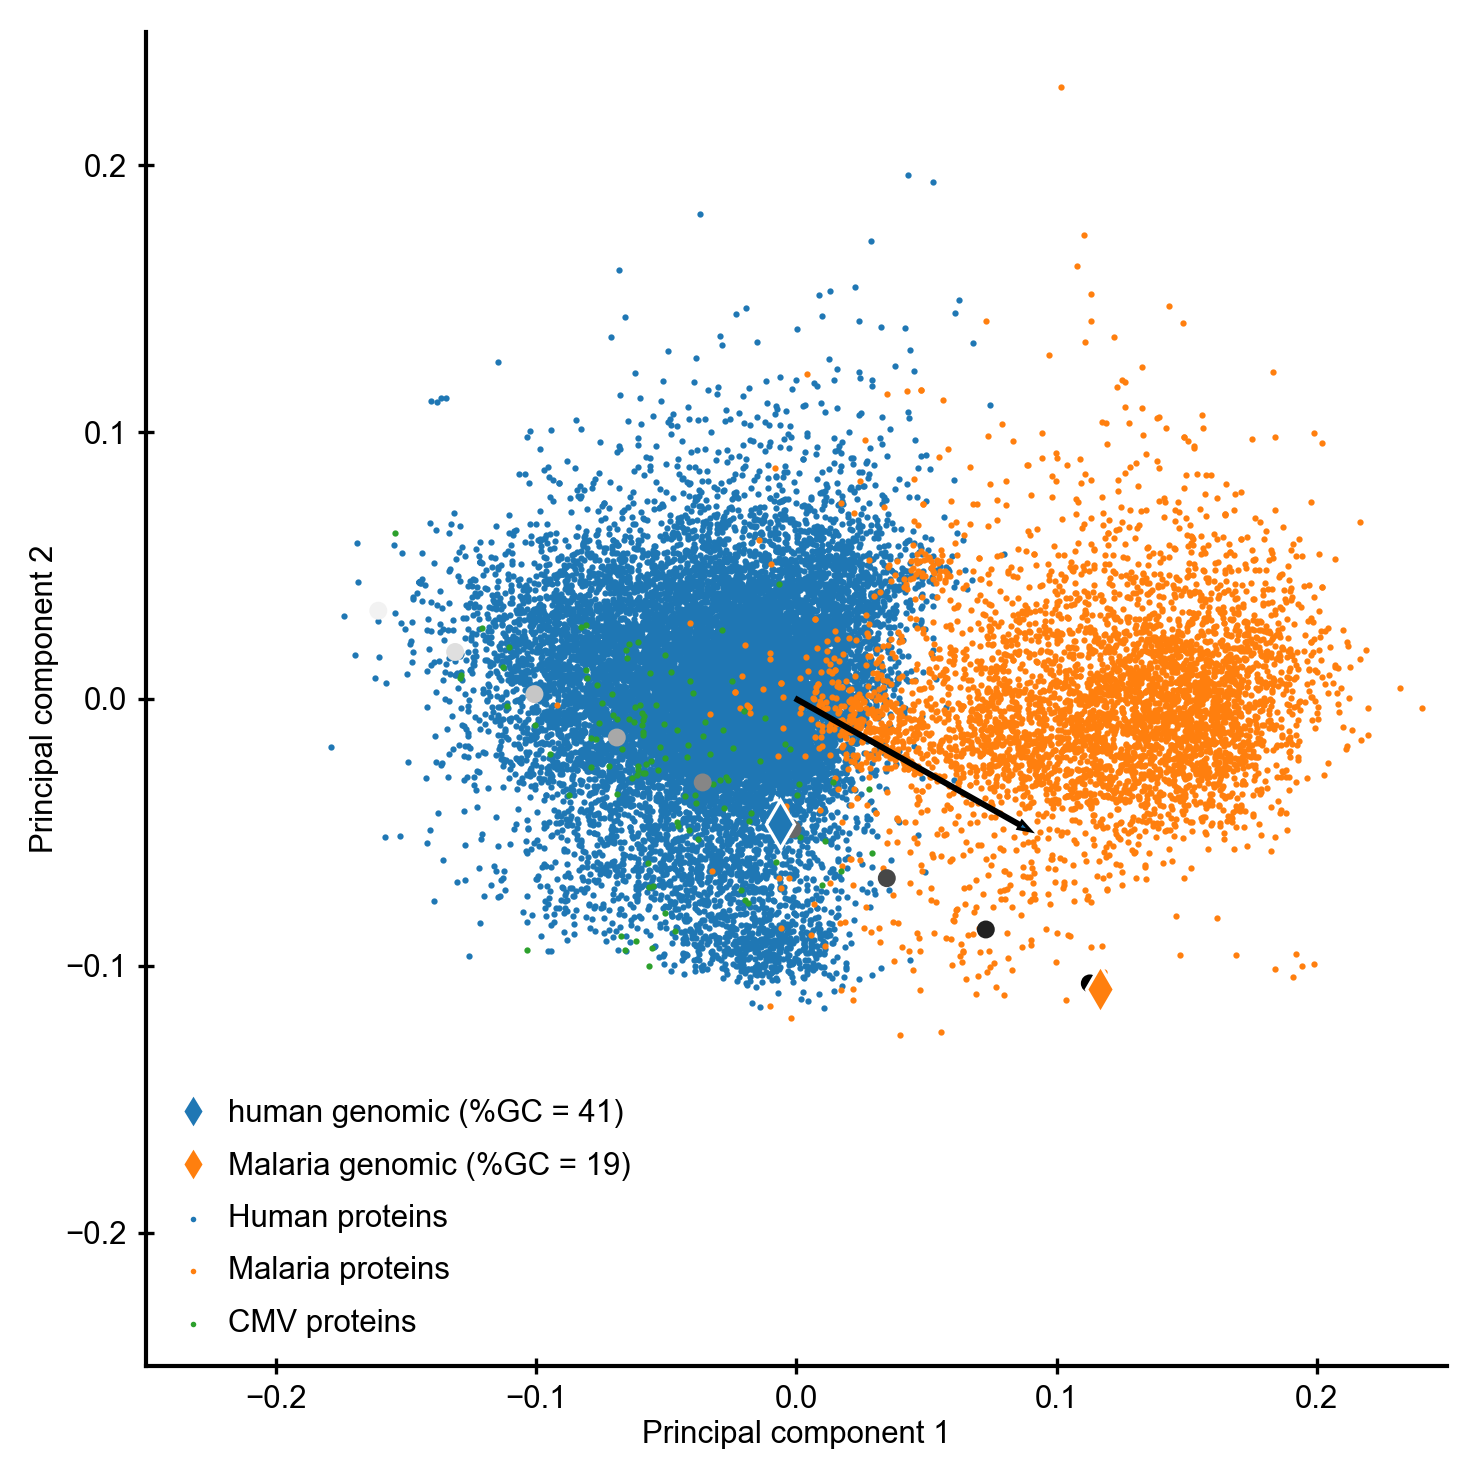

In [78]:
data = np.load('data/data.npz')

aa_cmv = data['cmv']
aa_malaria = data['malaria']
aa_human = data['human']

fig, ax = plt.subplots(figsize=(5, 5))
pca = sklearn.decomposition.PCA(n_components=2)
pca = pca.fit(np.vstack([aa_human, aa_malaria, aa_cmv]))
for label, aa in [('Human', aa_human), ('Malaria', aa_malaria), ('CMV', aa_cmv)]:
    pcad_pathogen = pca.transform(aa)
    ax.scatter(pcad_pathogen[:, 0], pcad_pathogen[:, 1], label=label+' proteins', s=.5)

freqss = []
pcomps = []
for filename in ['composition_human.tsv', 'composition_pfalciparum.tsv']:
    seqtk_columns = 'chr', 'length', '#A', '#C', '#G', "#T"
    composition = pd.read_csv('../aafreqs/data/%s'%filename, sep='\t',
                usecols=list(range(len(seqtk_columns))),
                names=seqtk_columns, index_col=0)
    pcomp = np.array([composition[seqtk_columns[i]].sum() for i in range(2, len(seqtk_columns))], dtype=np.float)
    pcomp /= np.sum(pcomp)
    pcomps.append(pcomp)
    frequencies = ntfreq_to_aafreq(pcomp)
    frequencies = [frequencies[aa] for aa in aminoacids]
    freqss.append(frequencies)
#frequencies = ntfreq_to_aafreq(np.ones(4)/4.0)
#frequencies = [frequencies[aa] for aa in aminoacids]
#freqss.append(frequencies)
freqss.append(np.ones(20)/20.0)
pcad = pca.transform(freqss)
ax.plot(pcad[0, 0], pcad[0, 1], 'd', markeredgecolor='w', ms=8, label=r'human genomic (%GC = '+'%g)'%round(np.sum(pcomps[0][1:3])*100))
ax.plot(pcad[1, 0], pcad[1, 1], 'd', markeredgecolor='w', ms=8, label=r'Malaria genomic (%GC = '+'%g)'%round(np.sum(pcomps[1][1:3])*100))
#ax.plot(pcad[2, 0], pcad[2, 1], 'd', markeredgecolor='w', ms=8, label='uniform genomic')
#ax.plot(pcad[2, 0], pcad[2, 1], 'kd', markeredgecolor='w', ms=8, label='uniform')

pgc = 0.42
pcomp = np.array([(1-pgc)/2, pgc/2, pgc/2, (1-pgc)/2])
freqs = lambda x: dict_to_array(ntfreq_to_aafreq(x))
delta = np.array([1,-1, -1, 1])
epsilon = 1e-3
deltaf = (freqs(pcomp+epsilon*delta)-freqs(pcomp))/epsilon
deltaf /= np.sum(deltaf**2)**.5
deltaf *= 0.1
deltaf_pcad = pca.transform(deltaf.reshape(1, -1))
plt.arrow(0, 0, deltaf_pcad[0, 0], deltaf_pcad[0, 1])

fpgc = lambda pgc: dict_to_array(ntfreq_to_aafreq(np.array([(1-pgc)/2, pgc/2, pgc/2, (1-pgc)/2])))
pgcs = np.linspace(0.2, 0.8, 10)
freqss = np.array([fpgc(pgc) for pgc in pgcs])
pcad = pca.transform(freqss)
ax.scatter(pcad[:, 0], pcad[:, 1], c=1-pgcs)


ax.legend()
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
lim = 0.25
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
fig.tight_layout()